# Building Data Genome Project 2.0
## Predictive models

Biam! (pic.biam@gmail.com)

In [1]:
# data and numbers
import numpy as np
import pandas as pd
import math
import datetime
from glob import glob
import gc

# Metrics & Models
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

In [2]:
path_metadata = "..\\data\\metadata\\"
path_weather = "..\\data\\weather\\"
path_meter_raw = "..\\data\\meters\\raw\\"
path_meter_cleaned = "..\\data\\meters\\cleaned\\"
path_meter_proc = "..\\data\\meters\\processed\\"

# Introduction

# Functions

In [3]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
# This function concatenate all prediction in one dataframe
# input: files directory list
# output: single dataframe with all predictions

def ConcatAllModels(files):
    dfs = [] # empty list of the dataframes to create
    for file in files: # for each file in directory
        
        model_name = file.split("\\")[3].split("_")[1].split(".")[0] # model_name to rename the model feature
        
        if model_name == "real": # don't rename column
            
            model = pd.read_csv(file) # load the dataset
            
        else: # rename column
            
            model = pd.read_csv(file, header=0, names=[model_name])
            
            
        dfs.append(model) # append to list
    complete_data = pd.concat(dfs, axis=1, ignore_index=False, sort=False) # concatenate all models
   
    return complete_data

# Datasets

## Feature selection

In this notebook only a selection of features will be used.<br>

<i>Building metadata</i>
<ul>
    <li>Building ID*</li>
    <li>Site ID*</li>
    <li>Primary space usage</li>
    <li>Building size (sqft)</li>
</ul>
<i>Weather data</i>
<ul>
    <li>Timestamp*</li>
    <li>Site ID*</li>
    <li>Air temperature</a></li>
</ul>
<i>Meter reading data</i>
<ul>
    <li>Timestamp*</li>
    <li>Building ID*</li>
    <li>meter</li>
    <li>meter reading (target)</li>
</ul>

## Metadata

**Buildings metadata**
<ul>
<li><code>building_id</code>: building code-name with the structure <i>UniqueFirstName_SiteID_primaryspaceusage</i>.</li>
<li><code>site_id</code>: animal-code-name for the site.</li>
<li><code>primaryspaceusage</code>: Primary space usage of all buildings is mapped using the <a href="https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/identify-your-property-type" rel="nofollow">energystar scheme building description types</a>. </li>
<li><code>sqft</code>: building area in square feet (sq ft). </li>
<li><code>lat</code>: latitude in degrees.</li>
<li><code>lng</code>: longitude in degrees.</li>
 <li><code>electricity</code>: presence of this kind of meter in the building. <code>Yes</code> if affirmative, <code>NaN</code> if negative.</li>
<li><code>hotwater</code>: presence of this kind of meter in the building. <code>Yes</code> if affirmative, <code>NaN</code> if negative.</li>
<li><code>chilledwater</code>: presence of this kind of meter in the building. <code>Yes</code> if affirmative, <code>NaN</code> if negative.</li>
<li><code>steam</code>: presence of this kind of meter in the building. <code>Yes</code> if affirmative, <code>NaN</code> if negative.</li>
<li><code>water</code>: presence of this kind of meter in the building. <code>Yes</code> if affirmative, <code>NaN</code> if negative.</li>
<li><code>irrigation</code>: presence of this kind of meter in the building. <code>Yes</code> if affirmative, <code>NaN</code> if negative.</li>
<li><code>solar</code>: presence of this kind of meter in the building. <code>Yes</code> if affirmative, <code>NaN</code> if negative.</li>
<li><code>gas</code>: presence of this kind of meter in the building. <code>Yes</code> if affirmative, <code>NaN</code> if negative./li>
<li><code>yearbuilt</code>: year built in the format YYYY.</li>
<li><code>numberoffloors</code>: number of floors.</li>
<li><code>date_opened</code>: date opened in the format D/M/YYYY.</li>
<li><code>sub_primaryspaceusage</code>: <a href="https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/identify-your-property-type" rel="nofollow">energystar scheme building description types</a> subcategory.</li>
<li><code>energystarscore</code>: <a href="https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/understand-metrics/how-1-100">Energy Star Score.</a></li>
<li><code>eui</code>: <a href="https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/understand-metrics/what-energy"> Energy use intensity.</a></li>
<li><code>heatingtype</code>: type of building's heating system.</li>
<li><code>industry</code>: building industry.</li>
<li><code>leed_level</code>: <a href"https://en.wikipedia.org/wiki/Leadership_in_Energy_and_Environmental_Design">Leadership in Energy and Environmental Design.</a></li>
<li><code>occupants</code>: number of ccupants?</li>
<li><code>rating</code>: building rating (system or criteria?)</li>
<li><code>site_eui</code>: site energy use intensity.</li>
<li><code>source_eui</code>: ?</li>
<li><code>sqm</code>: buildinga area in square meters?</li>
<li><code>subindustry</code>: building subindustry.</li>
<li><code>timezone</code>: time zone.</li>
</ul>

In [3]:
# Buildings metadata
metadata = pd.read_csv(path_metadata + "metadata.csv", usecols = ["building_id",
                                                                 "site_id",
                                                                 "primaryspaceusage",
                                                                 "sqft",
                                                                 ])

metadata = reduce_mem_usage(metadata)
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   building_id        1636 non-null   object 
 1   site_id            1636 non-null   object 
 2   primaryspaceusage  1615 non-null   object 
 3   sqft               1636 non-null   float64
dtypes: float64(1), object(3)
memory usage: 51.2+ KB


In [4]:
# missing values
metadata.isna().sum()*100/len(metadata)

building_id          0.000000
site_id              0.000000
primaryspaceusage    1.283619
sqft                 0.000000
dtype: float64

In [5]:
metadata[metadata.primaryspaceusage.isna() == True]

,building_id,site_id,primaryspaceusage,sqft
1179,Carri_Swan_Unknown,Swan,NaN,66247.0
1180,Johnna_Swan_Unknown,Swan,NaN,83272.0
1181,Dorris_Swan_Unknown,Swan,NaN,68026.0
1182,Jessie_Swan_Unknown,Swan,NaN,74574.0
1183,Randi_Swan_Unknown,Swan,NaN,75093.0
1184,Laurence_Swan_Unknown,Swan,NaN,92964.0
1185,Lanell_Swan_Unknown,Swan,NaN,159374.0
1186,Darrel_Swan_Unknown,Swan,NaN,49998.0
1187,Sherill_Swan_Unknown,Swan,NaN,160942.0
1188,Lashanda_Swan_Unknown,Swan,NaN,124202.0


In [6]:
metadata.primaryspaceusage.fillna("Unknown", inplace=True)

In [7]:
# missing values
metadata.isna().sum()*100/len(metadata)

building_id          0.0
site_id              0.0
primaryspaceusage    0.0
sqft                 0.0
dtype: float64

## Weather

**Weather**
* <code>timestamp</code>: date and time in the format YYYY-MM-DD hh:mm:ss. Local timezone.
* <code>site_id</code>: animal-code-name for the site.
* <code>airTemperature</code>: The temperature of the air in degrees Celsius (ºC).
* <code>cloudCoverage</code>: Portion of the sky covered in clouds, in [oktas](https://en.wikipedia.org/wiki/Okta).
* <code>dewTemperature</code>: The dew point (the temperature to which a given parcel of air must be cooled at constant pressure and water vapor content in order for saturation to occur) in degrees Celsius (ºC).
* <code>precipDepth1HR</code>: The depth of liquid precipitation that is measured over a one hour accumulation period (mm).
* <code>precipDepth6HR</code>: The depth of liquid precipitation that is measured over a six hour accumulation period (mm).
* <code>seaLvlPressure</code>: The air pressure relative to Mean Sea Level (MSL) (mbar or hPa).
* <code>windDirection</code>: The angle, measured in a clockwise direction, between true north and the direction from which the wind is blowing (degrees).
* <code>windSpeed</code>: The rate of horizontal travel of air past a fixed point (m/s).

In [27]:
# Weather data
weather = pd.read_csv(path_weather + "weather.csv", usecols = ["timestamp",
                                                                  "site_id",
                                                                  "airTemperature"
                                                                  ])
weather = reduce_mem_usage(weather)
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331166 entries, 0 to 331165
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       331166 non-null  object 
 1   site_id         331166 non-null  object 
 2   airTemperature  331038 non-null  float64
dtypes: float64(1), object(2)
memory usage: 7.6+ MB


In [28]:
weather.isna().sum()*100/len(weather)

timestamp         0.000000
site_id           0.000000
airTemperature    0.038651
dtype: float64

In [29]:
weather[weather.airTemperature.isna() == True]

,timestamp,site_id,airTemperature
363,2016-01-16 03:00:00,Panther,NaN
364,2016-01-16 04:00:00,Panther,NaN
365,2016-01-16 05:00:00,Panther,NaN
24523,2016-10-18 14:00:00,Robin,NaN
39855,2016-07-18 20:00:00,Fox,NaN
...,...,...,...
292657,2017-07-17 14:00:00,Peacock,NaN
292658,2017-07-17 15:00:00,Peacock,NaN
306959,2017-03-19 15:00:00,Cockatoo,NaN
309116,2017-06-18 19:00:00,Cockatoo,NaN


In [30]:
weather.airTemperature.interpolate(method="linear",inplace=True)

In [32]:
weather.isna().sum()*100/len(weather)

timestamp         0.0
site_id           0.0
airTemperature    0.0
dtype: float64

## Meters

### Join all cleaned datasets

In [3]:
# files in directory
files = glob(path_meter_cleaned + "*.csv")

In [4]:
files

['..\\data\\meters\\cleaned\\chilledwater_cleaned.csv',
 '..\\data\\meters\\cleaned\\electricity_cleaned.csv',
 '..\\data\\meters\\cleaned\\gas_cleaned.csv',
 '..\\data\\meters\\cleaned\\hotwater_cleaned.csv',
 '..\\data\\meters\\cleaned\\irrigation_cleaned.csv',
 '..\\data\\meters\\cleaned\\solar_cleaned.csv',
 '..\\data\\meters\\cleaned\\steam_cleaned.csv',
 '..\\data\\meters\\cleaned\\water_cleaned.csv']

In [7]:
dfs = [] # empty list of the dataframes to create
for file in files: # for each file in directory
    meter_type = file.split("\\")[4].split(".")[0].split("_")[0]# meter_type to rename the value feature
    meter = pd.read_csv(file) # load the dataset
    meter = pd.melt(meter, id_vars = "timestamp", var_name = "building_id", value_name = "meter_reading") # melt dataset
    meter["meter"] = str(meter_type) # adds column with the meter type
    dfs.append(meter) # append to list
complete_data = pd.concat(dfs, axis=0, ignore_index=True) # concatenate all meter
del(dfs, meter, file, files, meter_type)

In [8]:
complete_data.head()

,timestamp,building_id,meter_reading,meter
0,2016-01-01 00:00:00,Gwyneth_Panther_Office,NaN,chilledwater
1,2016-01-01 01:00:00,Gwyneth_Panther_Office,NaN,chilledwater
2,2016-01-01 02:00:00,Gwyneth_Panther_Office,NaN,chilledwater
3,2016-01-01 03:00:00,Gwyneth_Panther_Office,NaN,chilledwater
4,2016-01-01 04:00:00,Gwyneth_Panther_Office,NaN,chilledwater


In [9]:
# Check the meters
complete_data["meter"].value_counts()

electricity     27684432
chilledwater     9736920
steam            6491280
hotwater         3245640
gas              3105288
water            2561424
irrigation        649128
solar              87720
Name: meter, dtype: int64

In [10]:
# Check number of buildings
len(np.unique(complete_data["building_id"]))

1636

In [12]:
# Export dataset
complete_data.to_csv(path_meter_proc + "allmeters_cleaned.csv", index=False)

**All meters dataset (meter reading)**
<ul>
<li><code>timestamp</code>: date and time in the format YYYY-MM-DD hh:mm:ss. 2016 and 2017 data.</li>
<li><code>building_id</code>: building code-name with the structure <i>UniqueFirstName_SiteID_primaryspaceusage</i>.</li>
<li><code>meter_reading</code>: meter reading in kilowatt hour (kWh) .</li>
<li><code>meter</code>: meter type, <code>chilledwater</code>, <code>electricity</code>, <code>gas</code>, <code>hotwater</code>, <code>irrigation</code>, <code>steam</code> or <code>water</code>.</li>
</ul>

In [13]:
# Meters data
data = pd.read_csv(path_meter_proc + "allmeters_cleaned.csv")
data = reduce_mem_usage(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53561832 entries, 0 to 53561831
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      object 
 1   building_id    object 
 2   meter_reading  float64
 3   meter          object 
dtypes: float64(1), object(3)
memory usage: 1.6+ GB


In [33]:
# missing data
data.isna().sum()*100/len(data)

timestamp         0.000000
building_id       0.000000
meter_reading    15.849755
meter             0.000000
dtype: float64

In [34]:
# number of buildings in dataset
len(data.building_id.unique())

1636

In [35]:
# Drop missings
data.dropna(inplace=True)

In [36]:
# missing data
data.isna().sum()*100/len(data)

timestamp        0.0
building_id      0.0
meter_reading    0.0
meter            0.0
dtype: float64

In [37]:
# number of buildings in dataset after dropping Nan
len(data.building_id.unique())

1624

# Feature engineering based on EDA

 Based on [EDA of meter readings](https://github.com/buds-lab/building-data-genome-project-2/blob/master/notebooks/03_EDA-meter-reading.ipynb):
 <ul>
    <li><i>Healthcare</i> and <i>Utility</i> usages shows the highest meter reading values.</li>
    <li><i>Steam</i> meter shows the highest meter reading values.</li>
    <li>Monthly behaviour (meter-reading median):
    <ul>
        <li><i>Utility</i> usage peaks in April-March.</li>
        <li><i>Chilledwater</i> meter shows higher values in warm season.</li>
        <li><i>Steam</i> meter shows lower values in April-October.</li>
    </ul>
    </li>
    <li>Hourly behaviour (meter-reading median):
    <ul>
        <li>Higher values from 6 hs to 19 hs.</li>
        <li><i>Utility</i> usage shows oposite tendency.</li>
        <li><i>Steam</i> meter pikes from 5 hs to 8 hs.</li>
    </ul>
    </li>
        <li>Weekday behaviour: lowers during weekends.</li>
</ul>
</li>     
 Based on this observations <i>month</i>, <i>day of the week</i> and <i>hour of the day</i> will be added. <code>primaryspaceusage</code> categories (16) will be reduced to <i>healthcare, utility</i> and <i>other</i>. <code>meter</code> categories (8) will be preserved. Final features will be:
 <ul>
    <li>Timestamp*</li>
    <li>Site ID</li>
    <li>Building ID</li>
    <li>Month</li>
    <li>Hour</li>
    <li>Day of the week</li>
    <li>Usage (dummy, 3 levels: <i>healthcare, utility, other</i>)</li>
    <li>Building size (sqft)</li>
    <li>Air temperature</li>
    <li>Meter (dummy, 8 levels)</li>
    <li>Meter reading / target</li>
    

In [40]:
# Reduce primary space usage categories to 3: Healthcare, Utilty, other
metadata.loc[(metadata["primaryspaceusage"] != "Healthcare") & (metadata["primaryspaceusage"] != "Utility"), "primaryspaceusage"] = "other"

In [41]:
# Check new categories
metadata.primaryspaceusage.unique()

array(['other', 'Healthcare', 'Utility'], dtype=object)

In [42]:
# Converts to timestamp
data["timestamp"] = pd.to_datetime(data["timestamp"], format='%Y-%m-%d %H:%M:%S')
weather["timestamp"] = pd.to_datetime(weather["timestamp"], format='%Y-%m-%d %H:%M:%S')

In [43]:
# Add features
data["month"] = data.timestamp.dt.month
data["weekday"] = data.timestamp.dt.weekday
data["hour"] = data.timestamp.dt.hour

In [44]:
# Merge datasets
data = pd.merge(data, metadata, how="left", on="building_id").merge(weather, how="left", on = ["timestamp", "site_id"])

In [45]:
data.head()

,timestamp,building_id,meter_reading,meter,month,weekday,hour,site_id,primaryspaceusage,sqft,airTemperature
0,2016-02-29 09:00:00,Gwyneth_Panther_Office,464.313904,chilledwater,2,0,9,Panther,other,33370.0,16.703125
1,2016-02-29 10:00:00,Gwyneth_Panther_Office,759.786377,chilledwater,2,0,10,Panther,other,33370.0,21.093750
2,2016-02-29 11:00:00,Gwyneth_Panther_Office,801.996826,chilledwater,2,0,11,Panther,other,33370.0,21.703125
3,2016-02-29 12:00:00,Gwyneth_Panther_Office,844.207214,chilledwater,2,0,12,Panther,other,33370.0,22.203125
4,2016-02-29 13:00:00,Gwyneth_Panther_Office,928.627930,chilledwater,2,0,13,Panther,other,33370.0,23.906250


In [46]:
del(weather, metadata)

In [47]:
# Missing values
data.isna().sum()*100/len(data)

timestamp            0.000000
building_id          0.000000
meter_reading        0.000000
meter                0.000000
month                0.000000
weekday              0.000000
hour                 0.000000
site_id              0.000000
primaryspaceusage    0.000000
sqft                 0.000000
airTemperature       0.407089
dtype: float64

In [48]:
data.airTemperature.interpolate(method="linear", inplace=True)

In [49]:
data.isna().sum()*100/len(data)

timestamp            0.0
building_id          0.0
meter_reading        0.0
meter                0.0
month                0.0
weekday              0.0
hour                 0.0
site_id              0.0
primaryspaceusage    0.0
sqft                 0.0
airTemperature       0.0
dtype: float64

In [53]:
# Rounds to 4 decimals
data["meter_reading"] = data['meter_reading'].astype(float).round(4)
data["airTemperature"] = data['airTemperature'].astype(float).round(2)

In [54]:
data.head()

,timestamp,building_id,meter_reading,meter,month,weekday,hour,site_id,primaryspaceusage,sqft,airTemperature
0,2016-02-29 09:00:00,Gwyneth_Panther_Office,464.3139,chilledwater,2,0,9,Panther,other,33370.0,16.70
1,2016-02-29 10:00:00,Gwyneth_Panther_Office,759.7864,chilledwater,2,0,10,Panther,other,33370.0,21.09
2,2016-02-29 11:00:00,Gwyneth_Panther_Office,801.9968,chilledwater,2,0,11,Panther,other,33370.0,21.70
3,2016-02-29 12:00:00,Gwyneth_Panther_Office,844.2072,chilledwater,2,0,12,Panther,other,33370.0,22.20
4,2016-02-29 13:00:00,Gwyneth_Panther_Office,928.6279,chilledwater,2,0,13,Panther,other,33370.0,23.91


In [55]:
data.to_csv(path_meter_proc + "dev_merged.csv", index=False)

# Predictive models

## Long-term prediction: whole year 2017 prediction

**Train:** whole year 2016 (01/2016 to 12/2016)<br>
**Validation:** whole year 2017 (01/2017 to 12/2017)

<img src="..\\figures\\split_longterm.png">

In [4]:
# Load dataset
data = pd.read_csv(path_meter_proc + "dev_merged.csv")
# Reduce memory
data = reduce_mem_usage(data)

Mem. usage decreased to 2278.42 Mb (39.8% reduction)


In [5]:
# Rounds to 4 decimals
data["meter_reading"] = data['meter_reading'].astype(float).round(4)
data["airTemperature"] = data['airTemperature'].astype(float).round(2)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45077356 entries, 0 to 45077355
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   timestamp          object 
 1   building_id        object 
 2   meter_reading      float64
 3   meter              object 
 4   month              int8   
 5   weekday            int8   
 6   hour               int8   
 7   site_id            object 
 8   primaryspaceusage  object 
 9   sqft               float32
 10  airTemperature     float64
dtypes: float32(1), float64(2), int8(3), object(5)
memory usage: 2.6+ GB


In [7]:
data.head()

,timestamp,building_id,meter_reading,meter,month,weekday,hour,site_id,primaryspaceusage,sqft,airTemperature
0,2016-02-29 09:00:00,Gwyneth_Panther_Office,464.3139,chilledwater,2,0,9,Panther,other,33370.0,16.70
1,2016-02-29 10:00:00,Gwyneth_Panther_Office,759.7864,chilledwater,2,0,10,Panther,other,33370.0,21.09
2,2016-02-29 11:00:00,Gwyneth_Panther_Office,801.9968,chilledwater,2,0,11,Panther,other,33370.0,21.70
3,2016-02-29 12:00:00,Gwyneth_Panther_Office,844.2072,chilledwater,2,0,12,Panther,other,33370.0,22.20
4,2016-02-29 13:00:00,Gwyneth_Panther_Office,928.6279,chilledwater,2,0,13,Panther,other,33370.0,23.91


In [8]:
# Converts to timestamp
data["timestamp"] = pd.to_datetime(data["timestamp"], format='%Y-%m-%d %H:%M:%S')

In [9]:
# Strategy split
train = data[data["timestamp"] < "2017-01-01 00:00:00"]
val = data[data["timestamp"] >= "2017-01-01 00:00:00"]
del(data)

Let's check we have the same buildings in both datasets:

In [10]:
# List of unique buildings in each dataset
train_bdg = pd.DataFrame(train.building_id.unique()).rename(columns={0:"train"})
val_bdg = pd.DataFrame(val.building_id.unique()).rename(columns={0:"val"})
# Number of unique buildings in each dataset
print("Buildings in train: " + str(len(train_bdg)))
print("Buildings in val: " + str(len(val_bdg)))
# list of shared buildings in both datasets
shared_bdg = list(pd.merge(train_bdg, val_bdg, how="inner", left_on="train",right_on="val").drop("val",axis=1).rename(columns={"train":"unique_bdg"}).unique_bdg)
print("Buildings in val AND train: " + str(len(shared_bdg)))
del(train_bdg, val_bdg)

Buildings in train: 1589
Buildings in val: 1600
Buildings in val AND train: 1565


Let's select the shared buildings for the model:

In [11]:
train = train[train.building_id.isin(shared_bdg) == True]
val = val[val.building_id.isin(shared_bdg) == True]

In [12]:
# List of unique buildings in each dataset
train_bdg = pd.DataFrame(train.building_id.unique()).rename(columns={0:"train"})
val_bdg = pd.DataFrame(val.building_id.unique()).rename(columns={0:"val"})
# Number of unique buildings in each dataset
print("Buildings in train: " + str(len(train_bdg)))
print("Buildings in val: " + str(len(val_bdg)))
# list of shared buildings in both datasets
shared_bdg = list(pd.merge(train_bdg, val_bdg, how="inner", left_on="train",right_on="val").drop("val",axis=1).rename(columns={"train":"unique_bdg"}).unique_bdg)
print("Buildings in val AND train: " + str(len(shared_bdg)))
del(train_bdg, val_bdg, shared_bdg)

Buildings in train: 1565
Buildings in val: 1565
Buildings in val AND train: 1565


### Real values

In [15]:
val_real = val[["timestamp","building_id","meter","meter_reading"]]
val_real.to_csv("..\\data\\predictions\\longterm_real.csv", index=False)

In [16]:
values, counts = np.unique(val_real.meter_reading, return_counts=True)

In [17]:
print(values)
print(counts)

[0.00000000e+00 1.00000000e-04 2.00000000e-04 ... 4.73268938e+05
 4.79129656e+05 4.94695375e+05]
[1327286   59262   66623 ...       1       1       1]


In [18]:
print("Unique values: " + str(len(values)))
print("Min value: " + str(min(values)))
print("Max value: " + str(max(values)))

Unique values: 3169834
Min value: 0.0
Max value: 494695.375


In [19]:
del(val_real, values, counts)

### Encoding and Data/Target split

In [13]:
train = train.drop("timestamp",axis=1)
val = val.drop("timestamp",axis=1)

In [ ]:
"""train = train.set_index(["timestamp","building_id"])
val = val.set_index(["timestamp","building_id"])"""

For LightGBM use only a label encoding (this algorith can handle categorical features by itself):

In [15]:
# Label Encoder
le_meter = LabelEncoder().fit(train.meter)
train["meter"] = le_meter.transform(train.meter)
val["meter"] = le_meter.transform(val.meter)

In [16]:
# Label Encoder
le_usage = LabelEncoder().fit(train.primaryspaceusage)
train["primaryspaceusage"] = le_usage.transform(train.primaryspaceusage)
val["primaryspaceusage"] = le_usage.transform(val.primaryspaceusage)

In [17]:
# Label Encoder
le_usage = LabelEncoder().fit(train.building_id)
train["building_id"] = le_usage.transform(train.building_id)
val["building_id"] = le_usage.transform(val.building_id)

In [18]:
# Label Encoder
le_usage = LabelEncoder().fit(train.site_id)
train["site_id"] = le_usage.transform(train.site_id)
val["site_id"] = le_usage.transform(val.site_id)

In [19]:
# Split datasets
X_train = train.drop("meter_reading", axis=1)
y_train = train["meter_reading"]

X_val = val.drop("meter_reading", axis=1)
y_val = val["meter_reading"]

del(train, val)

### LightGBM prediction

Default parameters: https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [20]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(
    X_train,
    y_train,
    categorical_feature=["site_id","building_id","meter","month","weekday","hour","primaryspaceusage"],
    free_raw_data=False,
)
lgb_eval = lgb.Dataset(
    X_val,
    y_val,
    categorical_feature=["site_id","building_id","meter","month","weekday","hour","primaryspaceusage"],
    reference=lgb_train,
    free_raw_data=False,
)

In [29]:
# Parameters
params = {
    "objective": "regression",
    "metric": "rmse",
    "random_state": 55,
    "learning_rate":0.01, # default 0.1
    "max_bin":761, # Bin temperature by 0.1 ºC. default 255
    "num_leaves": 2197 # Around 0.01% of training data. default 31
}

In [30]:
# train
print('Starting training...')
gbm = lgb.train(params,
                lgb_train,
                valid_sets = lgb_eval,
                num_boost_round=100000,
                early_stopping_rounds=10000,
                verbose_eval=1000)

Starting training...


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10000 rounds
[1000]	valid_0's rmse: 113376
[2000]	valid_0's rmse: 114943
[3000]	valid_0's rmse: 115910
[4000]	valid_0's rmse: 116508
[5000]	valid_0's rmse: 116981
[6000]	valid_0's rmse: 117324
[7000]	valid_0's rmse: 117628
[8000]	valid_0's rmse: 117882
[9000]	valid_0's rmse: 118080
[10000]	valid_0's rmse: 118268
Early stopping, best iteration is:
[1]	valid_0's rmse: 3973.13


In [31]:
gbm.feature_importance()

array([ 293,   80,  209,   46,  166,    4,   17,  306, 1075])

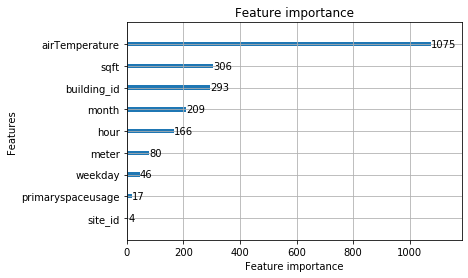

In [32]:
lgb.plot_importance(gbm)

In [33]:
# predict
print('Starting predicting...')
y_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
print('Finish.')

Starting predicting...
Finish.


In [34]:
values, counts = np.unique(y_pred, return_counts=True)

In [35]:
print(values)
print(counts)

[  1698.39969357   1698.44564018   1698.45764851 ... 137991.55189395
 150026.12264395 159704.21789395]
[ 229570 5804893  295462 ...      10      10      38]


In [36]:
print("Unique values: " + str(len(values)))
print("Min value: " + str(min(values)))
print("Max value: " + str(max(values)))

Unique values: 2183
Min value: 1698.3996935683324
Max value: 159704.21789394814


In [37]:
# Save LightGBM prediction
pd.DataFrame(y_pred).to_csv("..\\data\\predictions\\longterm_LGBM.csv", index=False, header="LGBM")

### Predictions dataset

To export a single dataset with all the predictions.

In [ ]:
del(X_train, X_val, y_train, y_val)
gc.collect()

In [5]:
# Filepath
files = glob("..\\data\\predictions\\longterm*")

In [6]:
files

['..\\data\\predictions\\longterm_LGBM.csv',
 '..\\data\\predictions\\longterm_real.csv']

In [23]:
df_pred = ConcatAllModels(files)

In [25]:
df_pred = df_pred[["timestamp","building_id","meter","meter_reading","LGBM"]]

In [26]:
df_pred.head()

,timestamp,building_id,meter,meter_reading,LGBM
0,2017-04-17 14:00:00,Gwyneth_Panther_Office,chilledwater,0.0000,1710.470333
1,2017-04-17 15:00:00,Gwyneth_Panther_Office,chilledwater,295.4725,1710.470333
2,2017-04-17 16:00:00,Gwyneth_Panther_Office,chilledwater,1055.2589,1710.721023
3,2017-04-17 17:00:00,Gwyneth_Panther_Office,chilledwater,970.8382,1710.721023
4,2017-04-17 18:00:00,Gwyneth_Panther_Office,chilledwater,844.2072,1710.721023


In [27]:
# Saves files
df_pred.to_csv("..\\data\\predictions\\longterm_pred.csv", index=False)

## Short term prediction

**train:** 1 month (core winter and summer months)<br>
**validation:** 3 days<br>
**test:** 3 days

<img src="..\\figures\\split_shorterm.png">

### Winter

In [5]:
# Load dataset
data = pd.read_csv(path_meter_proc + "dev_merged.csv")
# Reduce memory
data = reduce_mem_usage(data)

Mem. usage decreased to 2278.42 Mb (39.8% reduction)


In [6]:
# Rounds to 4 decimals
data["meter_reading"] = data['meter_reading'].astype(float).round(4)
data["airTemperature"] = data['airTemperature'].astype(float).round(2)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45077356 entries, 0 to 45077355
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   timestamp          object 
 1   building_id        object 
 2   meter_reading      float64
 3   meter              object 
 4   month              int8   
 5   weekday            int8   
 6   hour               int8   
 7   site_id            object 
 8   primaryspaceusage  object 
 9   sqft               float32
 10  airTemperature     float64
dtypes: float32(1), float64(2), int8(3), object(5)
memory usage: 2.6+ GB


In [8]:
data.head()

,timestamp,building_id,meter_reading,meter,month,weekday,hour,site_id,primaryspaceusage,sqft,airTemperature
0,2016-02-29 09:00:00,Gwyneth_Panther_Office,464.3139,chilledwater,2,0,9,Panther,other,33370.0,16.70
1,2016-02-29 10:00:00,Gwyneth_Panther_Office,759.7864,chilledwater,2,0,10,Panther,other,33370.0,21.09
2,2016-02-29 11:00:00,Gwyneth_Panther_Office,801.9968,chilledwater,2,0,11,Panther,other,33370.0,21.70
3,2016-02-29 12:00:00,Gwyneth_Panther_Office,844.2072,chilledwater,2,0,12,Panther,other,33370.0,22.20
4,2016-02-29 13:00:00,Gwyneth_Panther_Office,928.6279,chilledwater,2,0,13,Panther,other,33370.0,23.91


In [9]:
# Converts to timestamp
data["timestamp"] = pd.to_datetime(data["timestamp"], format='%Y-%m-%d %H:%M:%S')

In [10]:
# Strategy split
train = data[(data["timestamp"] >= "2017-01-01 00:00:00") & (data["timestamp"] < "2017-02-01 00:00:00")]
val = data[(data["timestamp"] >= "2017-02-01 00:00:00") & (data["timestamp"] < "2017-02-04 00:00:00")]
test = data[(data["timestamp"] >= "2017-02-04 00:00:00") & (data["timestamp"] < "2017-02-07 00:00:00")]
del(data)

Let's check we have the same buildings in all datasets:

In [11]:
# List of unique buildings in each dataset
train_bdg = pd.DataFrame(train.building_id.unique()).rename(columns={0:"bdg"})
val_bdg = pd.DataFrame(val.building_id.unique()).rename(columns={0:"bdg"})
test_bdg = pd.DataFrame(test.building_id.unique()).rename(columns={0:"bdg"})
# Number of unique buildings in each dataset
print("Buildings in train: " + str(len(train_bdg)))
print("Buildings in val: " + str(len(val_bdg)))
print("Buildings in test: " + str(len(test_bdg)))
# list of shared buildings in all datasets
shared_bdg = list(pd.merge(train_bdg, val_bdg, how="inner", on="bdg").merge(test_bdg, how="inner", on="bdg").bdg)
print("Buildings in val AND train AND test: " + str(len(shared_bdg)))

Buildings in train: 1583
Buildings in val: 1567
Buildings in test: 1568
Buildings in val AND train AND test: 1567


Let's select the shared buildings for the model:

In [13]:
train = train[train.building_id.isin(shared_bdg) == True]
val = val[val.building_id.isin(shared_bdg) == True]
test = test[test.building_id.isin(shared_bdg) == True]

### Real values

In [14]:
test_real = val[["timestamp","building_id","meter","meter_reading"]]
test_real.to_csv("..\\data\\predictions\\shortterm-winter_real.csv", index=False)

In [15]:
values, counts = np.unique(test_real.meter_reading, return_counts=True)

In [16]:
print(values)
print(counts)

[0.00000000e+00 2.00000000e-04 4.00000000e-04 ... 8.25000000e+04
 8.85014453e+04 9.48799297e+04]
[8502  144  144 ...    1    1    1]


In [17]:
print("Unique values: " + str(len(values)))
print("Min value: " + str(min(values)))
print("Max value: " + str(max(values)))

Unique values: 86500
Min value: 0.0
Max value: 94879.9297


In [19]:
del(test_real, values, counts)

### Encoding and Data/Target split

In [20]:
train = train.drop("timestamp",axis=1)
val = val.drop("timestamp",axis=1)
test = test.drop("timestamp",axis=1)

For LightGBM use only a label encoding (this algorith can handle categorical features by itself):

In [21]:
# Label Encoder
le_meter = LabelEncoder().fit(train.meter)
train["meter"] = le_meter.transform(train.meter)
val["meter"] = le_meter.transform(val.meter)
test["meter"] = le_meter.transform(test.meter)

In [22]:
# Label Encoder
le_usage = LabelEncoder().fit(train.primaryspaceusage)
train["primaryspaceusage"] = le_usage.transform(train.primaryspaceusage)
val["primaryspaceusage"] = le_usage.transform(val.primaryspaceusage)
test["primaryspaceusage"] = le_usage.transform(test.primaryspaceusage)

In [23]:
# Label Encoder
le_usage = LabelEncoder().fit(train.building_id)
train["building_id"] = le_usage.transform(train.building_id)
val["building_id"] = le_usage.transform(val.building_id)
test["building_id"] = le_usage.transform(test.building_id)

In [24]:
# Label Encoder
le_usage = LabelEncoder().fit(train.site_id)
train["site_id"] = le_usage.transform(train.site_id)
val["site_id"] = le_usage.transform(val.site_id)
test["site_id"] = le_usage.transform(test.site_id)

In [28]:
# Split datasets
X_train = train.drop("meter_reading", axis=1)
y_train = train["meter_reading"]

X_val = val.drop("meter_reading", axis=1)
y_val = val["meter_reading"]

X_test = test.drop("meter_reading", axis=1)
y_test = test["meter_reading"]

del(train, val, test)

### LightGBM prediction

Default parameters: https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [29]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(
    X_train,
    y_train,
    categorical_feature=["site_id","building_id","meter","month","weekday","hour","primaryspaceusage"],
    free_raw_data=False,
)
lgb_eval = lgb.Dataset(
    X_val,
    y_val,
    categorical_feature=["site_id","building_id","meter","month","weekday","hour","primaryspaceusage"],
    reference=lgb_train,
    free_raw_data=False,
)

lgb_test = lgb.Dataset(
    X_test,
    y_test,
    categorical_feature=["site_id","building_id","meter","month","weekday","hour","primaryspaceusage"],
    reference=lgb_train,
    free_raw_data=False,
)

In [30]:
# Parameters
params = {
    "objective": "regression",
    "metric": "rmse",
    "random_state": 55,
    "learning_rate":0.01, # default 0.1
    "max_bin":761, # Bin temperature by 0.1 ºC. default 255
    "num_leaves": 2197 # Around 0.01% of training data. default 31
}

In [31]:
# train
print('Starting training...')
gbm = lgb.train(params,
                lgb_train,
                valid_sets = lgb_eval,
                num_boost_round=100000,
                early_stopping_rounds=10000,
                verbose_eval=1000)

Starting training...


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10000 rounds
[1000]	valid_0's rmse: 760.108
[2000]	valid_0's rmse: 780.563
[3000]	valid_0's rmse: 797.874
[4000]	valid_0's rmse: 805.833
[5000]	valid_0's rmse: 810.404
[6000]	valid_0's rmse: 815.668
[7000]	valid_0's rmse: 818.829
[8000]	valid_0's rmse: 821.719
[9000]	valid_0's rmse: 824.869
[10000]	valid_0's rmse: 828.572
Early stopping, best iteration is:
[376]	valid_0's rmse: 731.758


In [32]:
gbm.feature_importance()

array([100264,  27692,      0,  41275,  73580,   2162,   9928, 173012,
       397783])

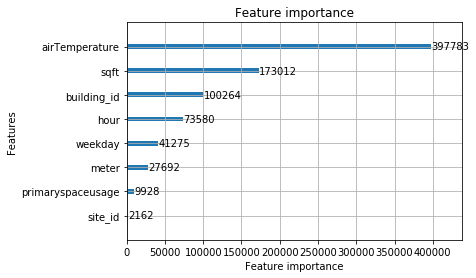

In [33]:
lgb.plot_importance(gbm)

In [34]:
# predict
print('Starting predicting...')
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
print('Finish.')

Starting predicting...
Finish.


In [35]:
values, counts = np.unique(y_pred, return_counts=True)

In [36]:
print(values)
print(counts)

[ -441.64330458  -439.83578342  -438.83045328 ... 67896.33722693
 67930.16518602 69023.43386595]
[1 1 1 ... 1 1 1]


In [37]:
print("Unique values: " + str(len(values)))
print("Min value: " + str(min(values)))
print("Max value: " + str(max(values)))

Unique values: 140278
Min value: -441.6433045755405
Max value: 69023.43386594887


In [43]:
# Save LightGBM prediction
pd.DataFrame(y_pred).to_csv("..\\data\\predictions\\shortterm-winter_LGBM.csv", index=False, header="LGBM")

### Predictions dataset

To export a single dataset with all the predictions.

In [39]:
del(X_train, X_val, y_train, y_val)
gc.collect()

286

In [90]:
# Filepath
files = glob("..\\data\\predictions\\shortterm-winter*")

In [91]:
files

['..\\data\\predictions\\shortterm-winter_LGBM.csv',
 '..\\data\\predictions\\shortterm-winter_real.csv']

In [92]:
df_pred = ConcatAllModels(files)

In [93]:
df_pred = df_pred[["timestamp","building_id","meter","meter_reading","LGBM"]]

In [94]:
df_pred.head()

,timestamp,building_id,meter,meter_reading,LGBM
0,2017-02-01 00:00:00,Jarrod_Panther_Lodging/residential,chilledwater,464.3139,1259.357777
1,2017-02-01 01:00:00,Jarrod_Panther_Lodging/residential,chilledwater,422.1036,1055.710598
2,2017-02-01 02:00:00,Jarrod_Panther_Lodging/residential,chilledwater,379.8932,899.462317
3,2017-02-01 03:00:00,Jarrod_Panther_Lodging/residential,chilledwater,295.4725,851.878107
4,2017-02-01 04:00:00,Jarrod_Panther_Lodging/residential,chilledwater,295.4725,769.181125


In [95]:
# Saves files
df_pred.to_csv("..\\data\\predictions\\shortterm-winter_pred.csv", index=False)

### Summer

In [50]:
# Load dataset
data = pd.read_csv(path_meter_proc + "dev_merged.csv")
# Reduce memory
data = reduce_mem_usage(data)

Mem. usage decreased to 2278.42 Mb (39.8% reduction)


In [51]:
# Rounds to 4 decimals
data["meter_reading"] = data['meter_reading'].astype(float).round(4)
data["airTemperature"] = data['airTemperature'].astype(float).round(2)

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45077356 entries, 0 to 45077355
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   timestamp          object 
 1   building_id        object 
 2   meter_reading      float64
 3   meter              object 
 4   month              int8   
 5   weekday            int8   
 6   hour               int8   
 7   site_id            object 
 8   primaryspaceusage  object 
 9   sqft               float32
 10  airTemperature     float64
dtypes: float32(1), float64(2), int8(3), object(5)
memory usage: 2.6+ GB


In [53]:
data.head()

,timestamp,building_id,meter_reading,meter,month,weekday,hour,site_id,primaryspaceusage,sqft,airTemperature
0,2016-02-29 09:00:00,Gwyneth_Panther_Office,464.3139,chilledwater,2,0,9,Panther,other,33370.0,16.70
1,2016-02-29 10:00:00,Gwyneth_Panther_Office,759.7864,chilledwater,2,0,10,Panther,other,33370.0,21.09
2,2016-02-29 11:00:00,Gwyneth_Panther_Office,801.9968,chilledwater,2,0,11,Panther,other,33370.0,21.70
3,2016-02-29 12:00:00,Gwyneth_Panther_Office,844.2072,chilledwater,2,0,12,Panther,other,33370.0,22.20
4,2016-02-29 13:00:00,Gwyneth_Panther_Office,928.6279,chilledwater,2,0,13,Panther,other,33370.0,23.91


In [54]:
# Converts to timestamp
data["timestamp"] = pd.to_datetime(data["timestamp"], format='%Y-%m-%d %H:%M:%S')

In [55]:
# Strategy split
train = data[(data["timestamp"] >= "2017-07-01 00:00:00") & (data["timestamp"] < "2017-08-01 00:00:00")]
val = data[(data["timestamp"] >= "2017-08-01 00:00:00") & (data["timestamp"] < "2017-08-04 00:00:00")]
test = data[(data["timestamp"] >= "2017-08-04 00:00:00") & (data["timestamp"] < "2017-08-07 00:00:00")]
del(data)

Let's check we have the same buildings in all datasets:

In [56]:
# List of unique buildings in each dataset
train_bdg = pd.DataFrame(train.building_id.unique()).rename(columns={0:"bdg"})
val_bdg = pd.DataFrame(val.building_id.unique()).rename(columns={0:"bdg"})
test_bdg = pd.DataFrame(test.building_id.unique()).rename(columns={0:"bdg"})
# Number of unique buildings in each dataset
print("Buildings in train: " + str(len(train_bdg)))
print("Buildings in val: " + str(len(val_bdg)))
print("Buildings in test: " + str(len(test_bdg)))
# list of shared buildings in all datasets
shared_bdg = list(pd.merge(train_bdg, val_bdg, how="inner", on="bdg").merge(test_bdg, how="inner", on="bdg").bdg)
print("Buildings in val AND train AND test: " + str(len(shared_bdg)))

Buildings in train: 1554
Buildings in val: 1544
Buildings in test: 1544
Buildings in val AND train AND test: 1542


Let's select the shared buildings for the model:

In [57]:
train = train[train.building_id.isin(shared_bdg) == True]
val = val[val.building_id.isin(shared_bdg) == True]
test = test[test.building_id.isin(shared_bdg) == True]

### Real values

In [58]:
test_real = val[["timestamp","building_id","meter","meter_reading"]]
test_real.to_csv("..\\data\\predictions\\shortterm-summer_real.csv", index=False)

In [59]:
values, counts = np.unique(test_real.meter_reading, return_counts=True)

In [60]:
print(values)
print(counts)

[0.00000000e+00 1.00000000e-04 2.00000000e-04 ... 6.11854375e+04
 6.86182188e+04 7.08580781e+04]
[12294   432   505 ...     1     1     1]


In [61]:
print("Unique values: " + str(len(values)))
print("Min value: " + str(min(values)))
print("Max value: " + str(max(values)))

Unique values: 92318
Min value: 0.0
Max value: 70858.0781


In [62]:
del(test_real, values, counts)

### Encoding and Data/Target split

In [63]:
train = train.drop("timestamp",axis=1)
val = val.drop("timestamp",axis=1)
test = test.drop("timestamp",axis=1)

For LightGBM use only a label encoding (this algorith can handle categorical features by itself):

In [64]:
# Label Encoder
le_meter = LabelEncoder().fit(train.meter)
train["meter"] = le_meter.transform(train.meter)
val["meter"] = le_meter.transform(val.meter)
test["meter"] = le_meter.transform(test.meter)

In [65]:
# Label Encoder
le_usage = LabelEncoder().fit(train.primaryspaceusage)
train["primaryspaceusage"] = le_usage.transform(train.primaryspaceusage)
val["primaryspaceusage"] = le_usage.transform(val.primaryspaceusage)
test["primaryspaceusage"] = le_usage.transform(test.primaryspaceusage)

In [66]:
# Label Encoder
le_usage = LabelEncoder().fit(train.building_id)
train["building_id"] = le_usage.transform(train.building_id)
val["building_id"] = le_usage.transform(val.building_id)
test["building_id"] = le_usage.transform(test.building_id)

In [67]:
# Label Encoder
le_usage = LabelEncoder().fit(train.site_id)
train["site_id"] = le_usage.transform(train.site_id)
val["site_id"] = le_usage.transform(val.site_id)
test["site_id"] = le_usage.transform(test.site_id)

In [68]:
# Split datasets
X_train = train.drop("meter_reading", axis=1)
y_train = train["meter_reading"]

X_val = val.drop("meter_reading", axis=1)
y_val = val["meter_reading"]

X_test = test.drop("meter_reading", axis=1)
y_test = test["meter_reading"]

del(train, val, test)

### LightGBM prediction

Default parameters: https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [69]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(
    X_train,
    y_train,
    categorical_feature=["site_id","building_id","meter","month","weekday","hour","primaryspaceusage"],
    free_raw_data=False,
)
lgb_eval = lgb.Dataset(
    X_val,
    y_val,
    categorical_feature=["site_id","building_id","meter","month","weekday","hour","primaryspaceusage"],
    reference=lgb_train,
    free_raw_data=False,
)

lgb_test = lgb.Dataset(
    X_test,
    y_test,
    categorical_feature=["site_id","building_id","meter","month","weekday","hour","primaryspaceusage"],
    reference=lgb_train,
    free_raw_data=False,
)

In [70]:
# Parameters
params = {
    "objective": "regression",
    "metric": "rmse",
    "random_state": 55,
    "learning_rate":0.01, # default 0.1
    "max_bin":761, # Bin temperature by 0.1 ºC. default 255
    "num_leaves": 2197 # Around 0.01% of training data. default 31
}

In [71]:
# train
print('Starting training...')
gbm = lgb.train(params,
                lgb_train,
                valid_sets = lgb_eval,
                num_boost_round=100000,
                early_stopping_rounds=10000,
                verbose_eval=1000)

Starting training...


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10000 rounds
[1000]	valid_0's rmse: 1043.85
[2000]	valid_0's rmse: 1076.6
[3000]	valid_0's rmse: 1098.99
[4000]	valid_0's rmse: 1115.63
[5000]	valid_0's rmse: 1127.39
[6000]	valid_0's rmse: 1135.8
[7000]	valid_0's rmse: 1142.47
[8000]	valid_0's rmse: 1148.25
[9000]	valid_0's rmse: 1151.83
[10000]	valid_0's rmse: 1154.39
Early stopping, best iteration is:
[141]	valid_0's rmse: 822.082


In [72]:
gbm.feature_importance()

array([ 48059,  11624,      0,  15410,  31288,    589,   4234,  65737,
       132695])

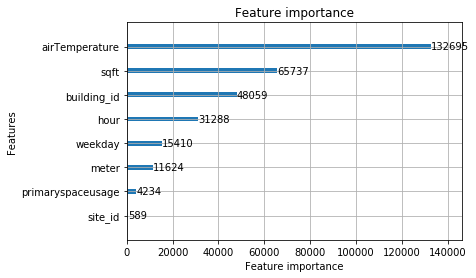

In [73]:
lgb.plot_importance(gbm)

In [74]:
# predict
print('Starting predicting...')
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
print('Finish.')

Starting predicting...
Finish.


In [75]:
values, counts = np.unique(y_pred, return_counts=True)

In [76]:
print(values)
print(counts)

[   73.88491224    94.09370852    94.41631054 ... 34060.32011671
 34887.93604767 35736.74736845]
[ 1  6 11 ...  1  1  1]


In [77]:
print("Unique values: " + str(len(values)))
print("Min value: " + str(min(values)))
print("Max value: " + str(max(values)))

Unique values: 58538
Min value: 73.88491223988439
Max value: 35736.74736845064


In [78]:
# Save LightGBM prediction
pd.DataFrame(y_pred).to_csv("..\\data\\predictions\\shortterm-summer_LGBM.csv", index=False, header="LGBM")

### Predictions dataset

To export a single dataset with all the predictions.

In [79]:
del(X_train, X_val, y_train, y_val)
gc.collect()

421

In [80]:
# Filepath
files = glob("..\\data\\predictions\\shortterm-summer*")

In [81]:
files

['..\\data\\predictions\\shortterm-summer_LGBM.csv',
 '..\\data\\predictions\\shortterm-summer_real.csv']

In [82]:
df_pred = ConcatAllModels(files)

In [83]:
df_pred = df_pred[["timestamp","building_id","meter","meter_reading","LGBM"]]

In [84]:
df_pred.head()

,timestamp,building_id,meter,meter_reading,LGBM
0,2017-08-01 00:00:00,Gwyneth_Panther_Office,chilledwater,844.2072,645.324614
1,2017-08-01 01:00:00,Gwyneth_Panther_Office,chilledwater,844.2072,620.794402
2,2017-08-01 02:00:00,Gwyneth_Panther_Office,chilledwater,801.9968,620.794402
3,2017-08-01 03:00:00,Gwyneth_Panther_Office,chilledwater,844.2072,659.043280
4,2017-08-01 04:00:00,Gwyneth_Panther_Office,chilledwater,844.2072,644.541422


In [86]:
# Saves files
df_pred.to_csv("..\\data\\predictions\\shortterm-summer_pred.csv", index=False)